In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import pygeohash as gh
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf
from copy import deepcopy as dc
import folium
import datetime as dt
import random as rnd
from catboost import Pool, FeaturesData, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import optuna
from collections import Counter

Dataset has start and end times, start and end locations of journeys and ride values.

In [ ]:
df = pd.read_csv("robotex5.csv")

###Data Exploration

There are no null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [ ]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [ ]:
df.start_time.min(), df.start_time.max()

('2022-03-01 00:00:07.936317000', '2022-03-28 23:59:53.175658000')

There are irrational coordinate values in end_lat and end_lng columns.

In [ ]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


There are duplicate rows.

In [ ]:
df.shape, df.drop_duplicates().shape

((627210, 6), (622646, 6))

### Exploratory Data Analysis

In [ ]:
df["start_time"] = pd.to_datetime(df["start_time"])

In [ ]:
df_eda = dc(df)

In [ ]:
df_eda["weekday"] = df_eda.start_time.dt.weekday
df_eda["date"] = df_eda.start_time.dt.date
df_eda['hour'] = df_eda.start_time.dt.hour

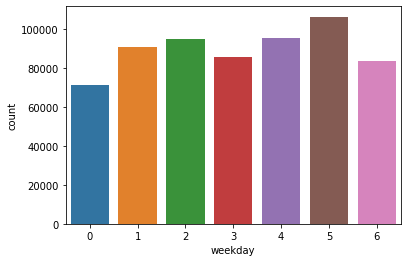

In [ ]:
sns.countplot(df_eda["weekday"])

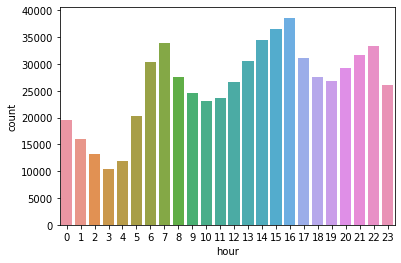

In [ ]:
 sns.countplot(df_eda["hour"])

There is an upward trend and a strong weekly seasonality.

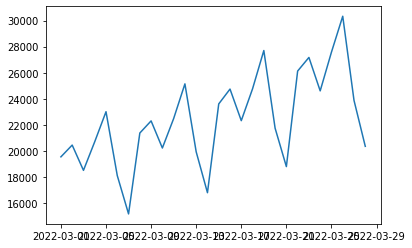

In [ ]:
daily_demand = df_eda.groupby("date").count().reset_index()
plt.plot("date","start_lat",data=daily_demand)

### Data Preprocessing

In [ ]:
def rm_outliers(data, col, threshold=3.0):
    z_scores = scipy.stats.zscore(data[col])
    abs_z_scores = np.abs(z_scores)
    data['zscore'] = abs_z_scores
    data.loc[data["zscore"]>threshold, col] = np.nan
    data=data.dropna()
    return data.drop("zscore",axis=1)

In [ ]:
df = df.drop_duplicates()

After trying different threshold values, irrational destination points are eliminated from data.

In [ ]:
df = rm_outliers(df, "end_lat", 2.85)
df = rm_outliers(df, "end_lng", 2.85)

After trying several precision values, start locations are divided into ~50 regions in the city.

In [ ]:
df['geohash_start'] = df.apply(lambda x: gh.encode(x.start_lat, x.start_lng, precision=5), axis=1)

In [ ]:
df.geohash_start.nunique()

48

In [ ]:
df_resampled = df.set_index("start_time")[["geohash_start","ride_value"]].groupby("geohash_start").resample("60Min").count().fillna(0).rename(columns={'ride_value':'demand'})['demand'].reset_index()

Since data includes only one year and month, I don't include year, month and day of month values in the dataset.

In [ ]:
df_resampled["weekday"] = df_resampled.start_time.dt.weekday
df_resampled["date"] = df_resampled.start_time.dt.date
df_resampled['hour'] = df_resampled.start_time.dt.hour

In [ ]:
df_resampled = df_resampled.sort_values(['geohash_start','start_time'])

In [ ]:
df_resampled.head()

,geohash_start,start_time,demand,weekday,date,hour
0,ud93t,2022-03-02 23:00:00,1,2,2022-03-02,23
1,ud93t,2022-03-03 00:00:00,0,3,2022-03-03,0
2,ud93t,2022-03-03 01:00:00,0,3,2022-03-03,1
3,ud93t,2022-03-03 02:00:00,0,3,2022-03-03,2
4,ud93t,2022-03-03 03:00:00,0,3,2022-03-03,3


From now on I will proceed with demand as the dependent variable in the forecast model.

I will build a model to forecast total demand on a specific region, day and hour. I will try a CatBoost model for this task. I need tabular data with autoregressive features, and calendar features. Since this is synthetic data, I will not include special day, event and weather information. Otherwise they would be important features.  

If I had more time, I would build an LSTM model with sliding window data as input. I would add calendar, special day and weather information of the target day-hour-region by constructing an attention layer.

I could also forecast total ride value per day-hour and region, but I prefer to first forecast demand and then anticipate total ride value by using average ride value statistics for each region and weekday and hour.

I'll test the forecast model on the last 2 days.

In [ ]:
forecast_start_date = "2022-03-27"
target_col = "demand"

For autoregressive features, I will try the first 24 hours, and the same hour's value for the 7 days. Then I will check the correlation of lag values with the target variable, then select accordingly.

In [ ]:
lag_vals = list(np.arange(1,25,1)) + list(np.arange(48,192,24))
for i in lag_vals:
    df_resampled['demand_lag_{}'.format(i)] = df_resampled.groupby(["geohash_start"])[target_col].shift(i).fillna(method='bfill')

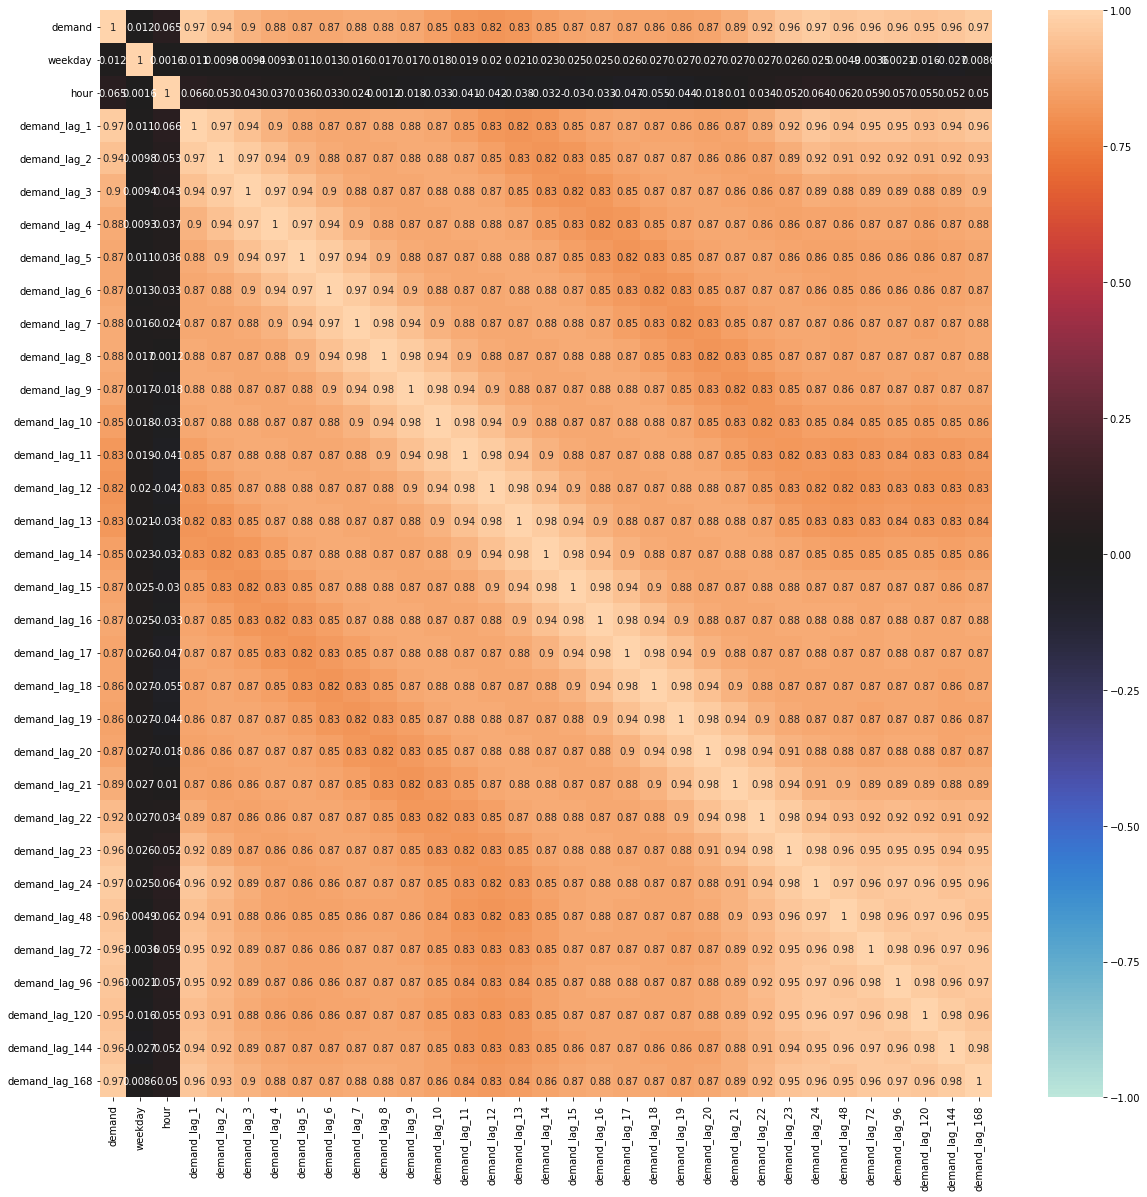

In [ ]:
plt.figure(figsize=[20,20])
sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

I will also check each region's time series for relevance with lagged values, and choose the most common ones.

In [ ]:
lags=[]
for region in df_resampled["geohash_start"].unique().tolist():
    temp = df_resampled[(df_resampled["geohash_start"]==region)&(df_resampled["date"]<pd.to_datetime(forecast_start_date))]
    lags.extend(temp.corr().iloc[0][temp.corr().iloc[0]>0.7].index)

In [ ]:
Counter(lags)

Counter({'demand': 47,
         'demand_lag_1': 7,
         'demand_lag_144': 3,
         'demand_lag_168': 8,
         'demand_lag_23': 2,
         'demand_lag_24': 7,
         'demand_lag_48': 5,
         'demand_lag_72': 6,
         'demand_lag_96': 4})

In [ ]:
num_column_list = ["demand_lag_1","demand_lag_24","demand_lag_72","demand_lag_168"]
cat_column_list = ["geohash_start","weekday","hour"]

for cat_col in cat_column_list:
    df_resampled[cat_col] = df_resampled[cat_col].astype("category")

for num_col in num_column_list:
    df_resampled[num_col] = df_resampled[num_col].astype(np.float32)
df_resampled[target_col] = df_resampled[target_col].astype(np.float32)

In [ ]:
df_test = df_resampled[df_resampled["date"]>=pd.to_datetime(forecast_start_date)]
df_train = df_resampled[df_resampled["date"]<pd.to_datetime(forecast_start_date)]

In [ ]:
X = df_train[num_column_list + cat_column_list]
y = df_train[target_col].values
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [ ]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in cat_column_list]

In [ ]:
def get_nmae(reals, preds):
    mae = np.nanmean((np.abs(reals - preds)))
    denominator = np.nanmean(reals)
    score = mae / (denominator + 0.0000001)
    return score

def get_rmse(reals, preds):
    rmse = np.sqrt(np.nanmean((reals - preds)**2))
    return rmse

def get_mae(reals, preds):
    mae = np.nanmean((np.abs(reals- preds)))
    return mae

def get_mape(reals, preds):
    mape = np.mean(np.abs((reals - preds)/(reals+0.000001)))*100
    return mape

In [ ]:
def objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), 
    }
    reg = CatBoostRegressor(**param, cat_features=categorical_features_indices)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    for train_index, test_index in tscv.split(X):
      X_train, X_test = X.values[train_index], X.values[test_index]
      y_train, y_test = y[train_index], y[test_index]
      reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)
      y_pred = reg.predict(X_test)
      score = get_mae(y_test, y_pred)
      scores.append(score)
    return np.array(score).mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=600) 
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-04-14 21:55:05,321] A new study created in memory with name: no-name-c99914c6-2947-4a2e-a5a8-1c7211831e20
[I 2022-04-14 21:55:45,925] Trial 0 finished with value: 1.7907427838392713 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.0004302715282368782, 'l2_leaf_reg': 0.29527519884455394, 'depth': 5, 'min_data_in_leaf': 3}. Best is trial 0 with value: 1.7907427838392713.
[I 2022-04-14 21:55:49,608] Trial 1 finished with value: 1.2096919332282383 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.6950171810652566, 'l2_leaf_reg': 0.20743553773367765, 'depth': 4, 'min_data_in_leaf': 11}. Best is trial 1 with value: 1.2096919332282383.
[I 2022-04-14 21:56:15,063] Trial 2 finished with value: 1.204018519357649 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.0015770554694270935, 'l2_leaf_reg': 0.2285159466311166, 'depth': 2, 'min_data_in_leaf': 8}. Best is trial 2 with value: 1.204018519357649.
[I 2022-04-14 21:56:20,173] Trial 3 finished with value: 1.4

Number of completed trials: 22
Best trial:
	Best Score: 1.067852625339775
	Best Params: 
    loss_function: MAE
    learning_rate: 0.10761917829682356
    l2_leaf_reg: 0.026128367105295855
    depth: 8
    min_data_in_leaf: 10


In [ ]:
train_pool = Pool(X_train.values, label = y_train, cat_features=categorical_features_indices)
eval_pool = Pool(X_val.values, label = y_val, cat_features=categorical_features_indices)
        
model = CatBoostRegressor(**trial.params, verbose=False)
model.fit(train_pool, eval_set=eval_pool, verbose_eval=False)

In [ ]:
y_pred = model.predict(df_test[num_column_list + cat_column_list].values)
y_pred = np.where(y_pred<0, 0, y_pred)

In [ ]:
get_mae(df_test[target_col].values, y_pred)

2.9119285442106646

In [ ]:
get_nmae(df_test[target_col].values, y_pred)

0.12956204593509363

In [ ]:
df_test = pd.concat([df_test.reset_index(drop=True),pd.Series(y_pred,name="prediction")],axis=1)

In [ ]:
nmae_regions = pd.DataFrame(df_test.groupby("geohash_start").apply(lambda x: get_nmae(x[target_col], x.prediction)))

In [ ]:
daily_demand_avg = df.groupby(["geohash_start",df.start_time.dt.date]).count().reset_index(level=0).groupby("geohash_start").mean()["start_lat"]

In [ ]:
nmae_regions.merge(daily_demand_avg, left_index=True, right_index=True).sort_values("start_lat")

,0,start_lat
geohash_start,,
ud93t,NaN,1.000000
ud93v,NaN,1.000000
ud99w,NaN,1.000000
ud996,0.999997,1.000000
ud993,NaN,1.000000
ud9dy,0.999999,1.062500
ud96r,1.000017,1.100000
ud9f0,1.111682,1.312500
ud93w,1.685486,1.357143


In [ ]:
df_test.sort_values(["start_time","prediction"], ascending=[True, False])[["geohash_start","start_time","demand","prediction"]]

,geohash_start,start_time,demand,prediction
1181,ud9d5,2022-03-27 00:00:00,512.0,497.112992
1133,ud9d4,2022-03-27 00:00:00,150.0,163.481653
531,ud99c,2022-03-27 00:00:00,60.0,46.883690
1275,ud9dh,2022-03-27 00:00:00,29.0,29.809839
673,ud99f,2022-03-27 00:00:00,23.0,23.260299
...,...,...,...,...
1696,ud9ds,2022-03-28 23:00:00,4.0,1.563709
93,ud93x,2022-03-28 23:00:00,1.0,1.459779
482,ud999,2022-03-28 23:00:00,2.0,0.957124
257,ud96n,2022-03-28 23:00:00,2.0,0.940398
